[1 - Prepare the data](#1---Prepare-the-data-)<br>
&ensp;&ensp;[1.1 - Generate annotation files](#1.1---Generate-annotation-files-(see-here))<br>
&ensp;&ensp;[1.2 - Create a subset for fast prototyping](#1.2---Create-a-subset-for-fast-prototyping)<br>
&ensp;&ensp;[1.3 - Compute features and write them to TFRecord](#1.3---Compute-features-and-write-them-to-TFRecord-files)<br>
&ensp;&ensp;[1.4 - Check some TFRecord](#1.4---Check-some-TFRecord)<br>
&ensp;&ensp;[1.5 - Check some other TFRecord](#1.5---Check-some-other-TFRecord)<br>
[2 - Training](#2---Training)<br>
&ensp;&ensp;[2.1 - Generate a train/valid split to monitor the performance on unseen data](#2.1---Generate-a-train/valid-split-to-monitor-the-performance-on-unseen-data)<br>
&ensp;&ensp;[2.2 - Count the number of batches in the train and valid sets](#2.2---Count-the-number-of-batches-in-the-train-and-valid-sets)<br>
&ensp;&ensp;[2.3 - Write feature extraction and training config files](#2.3---Write-feature-extraction-and-training-config-files)<br>
&ensp;&ensp;[2.4 - Train](#2.4---Train)


# 1 - Prepare the data

Original challenge data, as found at https://www.kaggle.com/c/freesound-audio-tagging-2019/data.
Audio data is resampled to 22050 Hz for faster prototyping.

In [1]:
! tree /home/jul/data/freesound-audio-tagging-2019/ -I 'subset*|annotations*|*wav|test'

/home/jul/data/freesound-audio-tagging-2019/
├── custom_subsets
│   └── train_config_example.json
├── sample_submission.csv
└── train
    ├── train_curated
    │   ├── audio
    │   ├── audio_22050hz
    │   └── train_curated.csv
    └── train_noisy
        ├── audio
        ├── audio_22050hz
        └── train_noisy.csv

8 directories, 4 files


## 1.1 - Generate annotation files (see [here](https://github.com/phaunos/phaunos_ml/blob/7fe9a4d07821a3ae0a5cdc353dc27fd332c5132c/phaunos_ml/utils/annotation_utils.py))

**Note**: Using annotation files here might be overkill because the annotations are "per file", but this is a generic way to handle any kind of annotations, including those applied to regions of a file (i.e. with start/end times).

In [2]:
from challenge_utils.dcase2019_task2_utils import get_class_list, generate_ann_files

In [3]:
class_list = get_class_list('/home/jul/data/freesound-audio-tagging-2019/sample_submission.csv')

In [4]:
print(class_list)

['Accelerating_and_revving_and_vroom', 'Accordion', 'Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Bass_guitar', 'Bathtub_(filling_or_washing)', 'Bicycle_bell', 'Burping_and_eructation', 'Bus', 'Buzz', 'Car_passing_by', 'Cheering', 'Chewing_and_mastication', 'Child_speech_and_kid_speaking', 'Chink_and_clink', 'Chirp_and_tweet', 'Church_bell', 'Clapping', 'Computer_keyboard', 'Crackle', 'Cricket', 'Crowd', 'Cupboard_open_or_close', 'Cutlery_and_silverware', 'Dishes_and_pots_and_pans', 'Drawer_open_or_close', 'Drip', 'Electric_guitar', 'Fart', 'Female_singing', 'Female_speech_and_woman_speaking', 'Fill_(with_liquid)', 'Finger_snapping', 'Frying_(food)', 'Gasp', 'Glockenspiel', 'Gong', 'Gurgling', 'Harmonica', 'Hi-hat', 'Hiss', 'Keys_jangling', 'Knock', 'Male_singing', 'Male_speech_and_man_speaking', 'Marimba_and_xylophone', 'Mechanical_fan', 'Meow', 'Microwave_oven', 'Motorcycle', 'Printer', 'Purr', 'Race_car_and_auto_racing', 'Raindrop', 'Run', 'Scissors', 'Screaming', 'Shatter', 

In [5]:
generate_ann_files('/home/jul/data/freesound-audio-tagging-2019/train', class_list)

Annotation file contains all annotations of a given audio file. Each line represent a region and one or more label ids:
    start_time,end_time(-1 if the annotation is for the whole audio file, as in our case),label_ids (joined by '#'):

In [6]:
!head -5 /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/* | head -8

==> /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/00097e21.ann <==
0.000,-1.000,7

==> /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/000b6cfb.ann <==
0.000,-1.000,51

==> /home/jul/data/freesound-audio-tagging-2019/train/train_noisy/annotations/00116cd2.ann <==
0.000,-1.000,37#47
head: error writing 'standard output': Broken pipe


## 1.2 - Create a subset for fast prototyping

In [7]:
import numpy as np
from phaunos_ml.utils.dataset_utils import create_subset, dataset_stat_per_file

In [8]:
# Pick 10 classes randomly
subset_label_set = set(np.random.choice(range(len(class_list)), 10, replace=False))
print(subset_label_set)

{66, 69, 13, 79, 48, 17, 49, 51, 50, 20}


In [9]:
# Create a data subset with all files annotated with at least one of these classes.
subset_filename = create_subset(
    '/home/jul/data/freesound-audio-tagging-2019/train/',
    ['train_noisy', 'train_curated'],
    '/home/jul/data/freesound-audio-tagging-2019/custom_subsets',
    audio_dirname='audio_22050hz',
    label_set=subset_label_set)
print(subset_filename)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1562320364/subset_1562320364.csv


This basically create a file with a unique name (*subset_&lt;timestamp&gt;.csv*) containing a list of files with their annotations (intersecting with label_set):

In [10]:
!head -10 "$subset_filename"

#class subset: 13,17,20,48,49,50,51,66,69,79
train_noisy/audio_22050hz/41731527.wav,66
train_noisy/audio_22050hz/54e14002.wav,66
train_noisy/audio_22050hz/d617b0fd.wav,49
train_noisy/audio_22050hz/6c3bbd98.wav,69
train_noisy/audio_22050hz/39e85c95.wav,50
train_noisy/audio_22050hz/4e7fd59b.wav,50
train_noisy/audio_22050hz/c5282d77.wav,17
train_noisy/audio_22050hz/c5d67f1d.wav,69
train_noisy/audio_22050hz/4626d9b7.wav,66


In [11]:
# Show dataset stats
# Note: The total number of instances might be higher than the number of audio files because a file might have multiple labels
count = dataset_stat_per_file(subset_filename)
print("Class index: number of instances") 
for k, v in sorted(count.items()): 
    print(f' {k:10}: {v}')

Class index: number of instances
         13: 375
         17: 375
         20: 375
         48: 349
         49: 375
         50: 375
         51: 375
         66: 375
         69: 372
         79: 375


## 1.3 - Compute features and write them to [TFRecord](https://www.tensorflow.org/tutorials/load_data/tf_records) files

In [12]:
import os
from phaunos_ml.utils.feature_utils import MelSpecExtractor
from phaunos_ml.utils.dataset_utils import dataset2tfrecords
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [13]:
# Log-mel spectrogram in 2s examples
feature_extractor = MelSpecExtractor(n_fft=512,
                                     hop_length=128,
                                     n_mels = 128,
                                     example_duration=2,
                                     example_hop_duration=1)

In [14]:
# Process our subset. TFRecords are written in 
tfrecord_path = os.path.join(os.path.dirname(subset_filename), 'features')
dataset2tfrecords('/home/jul/data/freesound-audio-tagging-2019/train/',
                 subset_filename,
                 tfrecord_path,
                 feature_extractor,
                 audio_dirname='audio_22050hz')

100%|██████████| 3687/3687 [07:49<00:00, 10.66it/s]


## 1.4 - Check some TFRecord

In [15]:
import random
import tensorflow as tf
from phaunos_ml.utils import tf_utils
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
subset_dir = os.path.dirname(subset_filename)
sometfrecord_path = os.path.join(subset_dir, 'features/train_curated/audio_22050hz/')

In [17]:
sometfrecord = os.path.join(
    sometfrecord_path,
    random.sample(os.listdir(sometfrecord_path), 1)[0]
)

In [18]:
print(sometfrecord)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1562320364/features/train_curated/audio_22050hz/185c6622.tf


In [19]:
someexamples = tf_utils.tfrecord2example(sometfrecord, feature_extractor)
print(someexamples)

W0705 12:00:35.384245 140111193732928 deprecation.py:323] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:44: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W0705 12:00:35.391460 140111193732928 deprecation_wrapper.py:119] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:51: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



[{'data': array([[-13.902429 ,  -7.037757 ,  -5.8599625, ..., -11.7304735,
         -6.1841836,  -5.8778543],
       [-14.2121   ,  -7.3514347,  -6.1736436, ..., -12.043698 ,
         -6.497864 ,  -6.1915355],
       [ -9.275022 ,  -8.074606 ,  -7.0462494, ...,  -6.4977746,
         -6.105831 ,  -6.332826 ],
       ...,
       [-18.395044 , -18.00077  , -17.628473 , ..., -17.924175 ,
        -17.823065 , -17.714407 ],
       [-18.404737 , -18.331776 , -18.165207 , ..., -18.057333 ,
        -17.734415 , -17.73154  ],
       [-18.387701 , -18.316486 , -18.143171 , ..., -18.170853 ,
        -18.096136 , -18.09683  ]], dtype=float32), 'filename': b'train_curated/audio_22050hz/185c6622.tf', 'labels': b'69', 'times': array([0.      , 1.996916], dtype=float32)}, {'data': array([[ -8.955656 ,  -8.597877 ,  -7.223806 , ...,  -8.850435 ,
         -6.7670746,  -5.7482843],
       [ -9.26931  ,  -8.911538 ,  -7.537483 , ...,  -9.164092 ,
         -7.080754 ,  -6.0619655],
       [ -7.9606624,  -7.

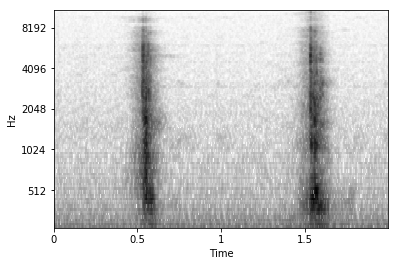

In [20]:
# First example in the TFRecord
feature_extractor.plot(someexamples[0]['data'])

## 1.5 - Check some other TFRecord

In [21]:
someothertfrecord = os.path.join(
    sometfrecord_path,
    random.sample(os.listdir(sometfrecord_path), 1)[0]
)
print(someothertfrecord)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1562320364/features/train_curated/audio_22050hz/7cfccc1f.tf


### As examples

In [22]:
otherexamples = tf_utils.tfrecord2example(someothertfrecord, feature_extractor)

In [23]:
print(otherexamples)

[{'data': array([[ -1.5819604 ,  -1.6850057 ,  -3.2806747 , ...,  -5.2381616 ,
         -3.8458397 ,  -2.3427765 ],
       [ -1.8956428 ,  -1.998688  ,  -3.594357  , ...,  -5.551843  ,
         -4.159522  ,  -2.656459  ],
       [ -3.4521756 ,  -1.444017  ,  -0.99468243, ...,  -3.8704045 ,
         -3.7627242 ,  -2.5237422 ],
       ...,
       [-11.473324  , -11.254861  , -12.14935   , ..., -11.13836   ,
        -11.83399   , -11.844822  ],
       [-12.357094  , -13.073742  , -12.794939  , ..., -11.719347  ,
        -12.358521  , -12.729061  ],
       [-12.049963  , -12.564434  , -13.203625  , ..., -12.734195  ,
        -11.845761  , -12.1483345 ]], dtype=float32), 'filename': b'train_curated/audio_22050hz/7cfccc1f.tf', 'labels': b'17', 'times': array([0.      , 1.996916], dtype=float32)}, {'data': array([[ -2.072989  ,  -2.8802063 ,  -2.2213206 , ...,  -4.1734915 ,
         -1.7521002 ,  -0.42847452],
       [ -2.3866715 ,  -3.1938887 ,  -2.535003  , ...,  -4.4871736 ,
         -2.06

### As input (features + one-hot encoded labels) to the model

In [ ]:
subset_class_list = sorted(list(subset_label_set)) # labels are one-hot encoded according to this list

In [ ]:
print(subset_class_list)

[13, 17, 20, 48, 49, 50, 51, 66, 69, 79]


In [ ]:
example_as_input = tf_utils.tfrecord2data(someothertfrecord, feature_extractor, subset_class_list)

W0705 12:00:36.067301 140111193732928 deprecation.py:323] From /home/jul/dev/phaunos_ml/phaunos_ml/utils/tf_utils.py:143: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# model_input is a list of tuple (<features>, <one-hot encoded labels>)
print(example_as_input)

[(array([[[ -1.5819604 ,  -1.6850057 ,  -3.2806747 , ...,  -5.2381616 ,
          -3.8458397 ,  -2.3427765 ],
        [ -1.8956428 ,  -1.998688  ,  -3.594357  , ...,  -5.551843  ,
          -4.159522  ,  -2.656459  ],
        [ -3.4521756 ,  -1.444017  ,  -0.99468243, ...,  -3.8704045 ,
          -3.7627242 ,  -2.5237422 ],
        ...,
        [-11.473324  , -11.254861  , -12.14935   , ..., -11.13836   ,
         -11.83399   , -11.844822  ],
        [-12.357094  , -13.073742  , -12.794939  , ..., -11.719347  ,
         -12.358521  , -12.729061  ],
        [-12.049963  , -12.564434  , -13.203625  , ..., -12.734195  ,
         -11.845761  , -12.1483345 ]]], dtype=float32), array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)), (array([[[ -2.072989  ,  -2.8802063 ,  -2.2213206 , ...,  -4.1734915 ,
          -1.7521002 ,  -0.42847452],
        [ -2.3866715 ,  -3.1938887 ,  -2.535003  , ...,  -4.4871736 ,
          -2.0657825 ,  -0.7421569 ],
        [ -2.436786  ,  -3.370003  , 

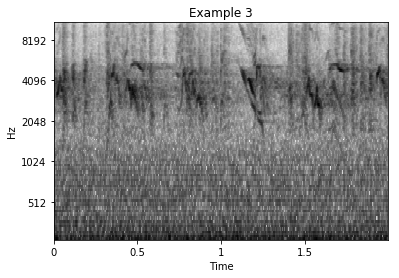

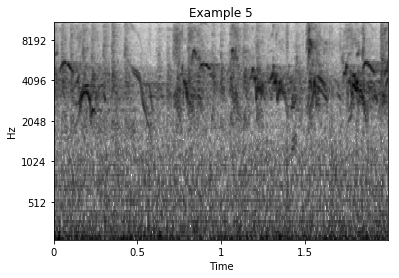

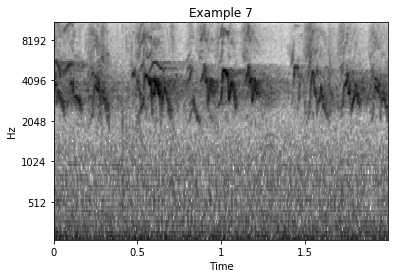

In [ ]:
# Plot features for random examples from the selected file
ind = sorted(random.sample(range(len(example_as_input)),min(len(example_as_input), 3)))
for i in ind:    
    plt.figure()
    feature_extractor.plot(example_as_input[i][0][0])
    plt.title(f'Example {i}')

# 2 - Training

## 2.1 - Generate a train/valid split to monitor the performance on unseen data

In [ ]:
from phaunos_ml.utils.dataset_utils import split_dataset

In [ ]:
# This generates 2 files,
# /subset/path/subset_name.train.csv containing 80% of the data (training dataset)
# /subset/path/subset_name.test.csv containing 20% of the data (validation dataset, to select the model)
split_dataset(subset_filename, test_size=0.2)

/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1562320364/subset_1562320364.train.csv written
/home/jul/data/freesound-audio-tagging-2019/custom_subsets/subset_1562320364/subset_1562320364.test.csv written


## 2.2 - Count the number of batches in the train and valid sets

In [ ]:
from phaunos_ml.utils.dataset_utils import dataset_stat_per_example
BATCH_SIZE = 32

In [ ]:
# training set
n_train_batches, n_train_examples_per_class = dataset_stat_per_example(
    subset_filename.replace('.csv', '.train.csv'),
    os.path.join(os.path.dirname(subset_filename), 'features'),
    feature_extractor.feature_shape,
    subset_class_list,
    batch_size=BATCH_SIZE)
print(f'Num training batches: {n_train_batches} (i.e. {n_train_batches * BATCH_SIZE} examples)')
for c, n in zip(subset_class_list, n_train_examples_per_class):
    print(f'Class {c:2}: {n} examples')
# Note: the number of examples n_train_batches * BATCH_SIZE is <= to sum(n_train_examples_per_class)
# because data is multilabel
print(f'{n_train_batches * BATCH_SIZE} <= {np.sum(n_train_examples_per_class)}')

Num training batches: 1260 (i.e. 40320 examples)
Class 13: 3925 examples
Class 17: 3927 examples
Class 20: 4167 examples
Class 48: 4190 examples
Class 49: 3737 examples
Class 50: 3853 examples
Class 51: 4245 examples
Class 66: 4527 examples
Class 69: 4310 examples
Class 79: 3894 examples
40320 <= 40775


In [ ]:
# valid set
n_valid_batches, n_valid_examples_per_class = dataset_stat_per_example(
    subset_filename.replace('.csv', '.test.csv'),
    os.path.join(os.path.dirname(subset_filename), 'features'),
    feature_extractor.feature_shape,
    subset_class_list,
    batch_size=BATCH_SIZE)
print(f'Num valid batches: {n_valid_batches} (i.e. {n_valid_batches * BATCH_SIZE} examples)')
for c, n in zip(subset_class_list, n_valid_examples_per_class):
    print(f'Class {c:2}: {n} examples')
# Note: the number of examples n_valid_batches * BATCH_SIZE is <= to sum(n_valid_examples_per_class)
# because data is multilabel
print(f'{n_valid_batches * BATCH_SIZE} <= {np.sum(n_valid_examples_per_class)}')

Num valid batches: 335 (i.e. 10720 examples)
Class 13: 1099 examples
Class 17: 1069 examples
Class 20: 1090 examples
Class 48: 990 examples
Class 49: 1084 examples
Class 50: 1091 examples
Class 51: 1112 examples
Class 66: 1078 examples
Class 69: 1083 examples
Class 79: 1084 examples
10720 <= 10780


## 2.3 - Write feature extraction and training config files

In [ ]:
import json

EPOCHS = 10

In [ ]:
# Write feature extractor's config file
feature_extractor.config2file(os.path.join(subset_dir, 'features', 'featex_config.json'))

In [ ]:
# Write training config file

training_dir = os.path.join(subset_dir, 'training')

training_config = {}
training_config['feature_path'] = os.path.join(subset_dir, 'features')
training_config['train_set_file'] = subset_filename.replace('.csv', '.train.csv')
training_config['n_train_batches'] = n_train_batches
training_config['batch_size'] = BATCH_SIZE
training_config['multilabel'] = True
training_config['epochs'] = EPOCHS
training_config['out_dir'] = training_dir
training_config['valid_set_file'] = subset_filename.replace('.csv', '.test.csv')
training_config['n_valid_batches'] = n_valid_batches

training_config_path = os.path.join(training_dir, 'training_config.json')
os.makedirs(training_dir)

with open(training_config_path, 'w') as training_config_file:
    json.dump(training_config, training_config_file)

## 2.4 - Train

In [ ]:
from phaunos_ml import train

In [ ]:
train.process(training_config_path)

W0705 12:01:19.140022 140111193732928 deprecation.py:506] From /home/jul/.miniconda3/envs/phaunos_ml/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mels (InputLayer)            [(32, 1, 128, 344)]       0         
_________________________________________________________________
l1_conv (Conv2D)             (32, 32, 126, 342)        288       
_________________________________________________________________
l1_bn (BatchNormalization)   (32, 32, 126, 342)        96        
_________________________________________________________________
l1 (Activation)              (32, 32, 126, 342)        0         
_________________________________________________________________
l1_mp (MaxPooling2D)         (32, 32, 62, 170)         0         
_________________________________________________________________
l2_conv (Conv2D)             (32, 32, 58, 166)         25600     
_________________________________________________________________
l2_bn (BatchNormalization)   (32, 32, 58, 166)         96    